In [1]:
import community
import numpy as np
import pandas as pd
import networkx as nx

from scipy.cluster import hierarchy
from scipy.spatial import distance

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
G = nx.karate_club_graph()
G.remove_edge(22,33)
np.random.seed(0)
pos = nx.fruchterman_reingold_layout(G)

In [3]:
print("Number of nodes: ", G.order())
print("Number of edges: ", G.size())

Number of nodes:  34
Number of edges:  77


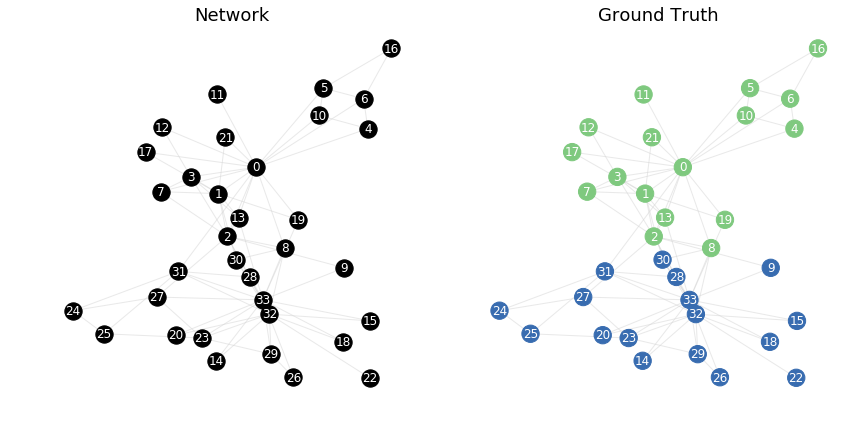

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
[ax.axis("off") for ax in axes]

axes[0].set_title("Network", fontsize=18)

nx.draw_networkx_nodes(G, pos, node_size=300, 
                       node_color='black',
                       cmap=plt.cm.inferno,
                       ax=axes[0])
nx.draw_networkx_edges(G, pos, alpha=0.500, edge_color='lightgray', ax=axes[0])

nx.draw_networkx_labels(G, pos, font_color="white", ax=axes[0])

axes[1].set_title("Ground Truth", fontsize=18)
node_list = list(G.nodes())

mrhi = [0,1,2,3,4,5,6,7,8,10,11,12,13,16,17,19,21]
node_color_members = [0 if m in mrhi else 1 for m in node_list]

nx.draw_networkx_nodes(G, pos, node_size=300, 
                       node_list=node_list,
                       node_color=node_color_members,
                       cmap=plt.cm.Accent,
                       vmin=0,
                       vmax=2,
                       ax=axes[1])
nx.draw_networkx_edges(G, pos, alpha=0.500, edge_color='lightgray', ax=axes[1])

nx.draw_networkx_labels(G, pos, font_color="white", ax=axes[1])
fig.tight_layout()

In [5]:
cliques = list(nx.find_cliques(G))
print(cliques)

[[0, 1, 17], [0, 1, 2, 3, 13], [0, 1, 2, 3, 7], [0, 1, 19], [0, 1, 21], [0, 4, 10], [0, 4, 6], [0, 5, 10], [0, 5, 6], [0, 8, 2], [0, 11], [0, 12, 3], [0, 31], [32, 33, 8, 30], [32, 33, 14], [32, 33, 15], [32, 33, 18], [32, 33, 20], [32, 33, 23, 29], [32, 33, 31], [32, 2, 8], [32, 22], [33, 9], [33, 13], [33, 19], [33, 26, 29], [33, 27, 23], [33, 28, 31], [9, 2], [16, 5, 6], [23, 25], [24, 25, 31], [24, 27], [27, 2], [28, 2], [30, 1]]


In [6]:
edge_betweenness = nx.edge_betweenness_centrality(G)
edge_betweenness = sorted(edge_betweenness.items(), key=lambda x: -x[1])
edge_betweenness[:5]

[((0, 31), 0.1280225221401692),
 ((0, 2), 0.08082788671023965),
 ((0, 6), 0.07813428401663695),
 ((0, 5), 0.07813428401663694),
 ((2, 32), 0.07708740061681237)]

In [7]:
def pop_by_edge_betweenness(G, k):
    for _ in range(k):
        edge_betweenness = nx.edge_betweenness_centrality(G)
        edge_betweenness, _ = zip(*sorted(edge_betweenness.items(), key=lambda x: -x[1]))
        G.remove_edge(*edge_betweenness[0])
    return G

In [8]:
pop_nums = [0, 10, 15, 20]

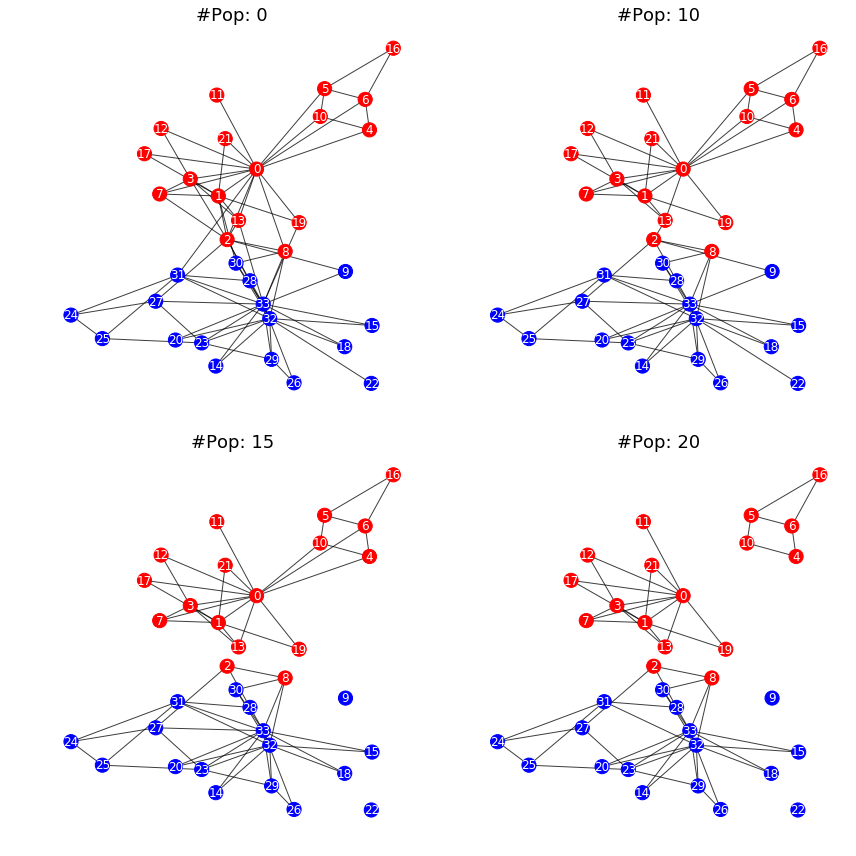

In [9]:
fig, axes = plt.subplots(2, 2, figsize = (12, 12))

for i, ax in enumerate(axes.reshape(-1)):
    popped_graph = pop_by_edge_betweenness(G.copy(), pop_nums[i])
    
    ax.set_title("#Pop: %d" % pop_nums[i], fontsize=18)
    ax.axis("off")
    
    node_list = list(popped_graph.nodes())

    mrhi = [0,1,2,3,4,5,6,7,8,10,11,12,13,16,17,19,21]
    node_color = ['r' if m in mrhi else 'b' for m in node_list]

    nx.draw_networkx_nodes(popped_graph, pos, node_size=200, 
                           node_list=node_list,
                           node_color=node_color,
                           ax=ax)
    nx.draw_networkx_edges(popped_graph, pos, alpha=0.75, edge_color='black', ax=ax)

    nx.draw_networkx_labels(popped_graph, pos, font_color="white", ax=ax)
fig.tight_layout()

In [10]:
G_clustered = pop_by_edge_betweenness(G.copy(), 15)

In [11]:
print("Number of components: ", len(list(nx.connected_components(G_clustered))),"\n")
connected_components = list(nx.connected_components(G_clustered))
node_list = [node for component in connected_components for node in component]
node_color = [i for i, component in enumerate(connected_components) for node in component]
_, node_color_edge_betweenness = zip(*sorted(zip(node_list, node_color), key=lambda x: x[0]))

Number of components:  4 



In [12]:
__author__ = """\n""".join(['Erika Fille Legara <legareft@ihpc.a-star.edu.sg>',
                            'Maksim Tsvetovat <maksim@tsvetovat.org',
                            'Drew Conway <drew.conway@nyu.edu>',
                            'Aric Hagberg <hagberg@lanl.gov>'])
    
'''
The original code was written by Drew Conway and Aric Hagberg and was later 
modified by Maksim Tsvetovat for his book titled “Social Network Analysis for Startups”.
EF Legara slightly modified Tsvetovat's version to address some issues 
on the ordering of keys within the path_length dictionary. Moreover,
in this code, a different agglomerative procedure is implemented.
'''

def create_hc(G, t):
    ## Set-up the distance matrix D
    labels=list(G.nodes())    # keep node labels
    path_length=dict(nx.all_pairs_shortest_path_length(G))
    distances=np.zeros((len(G),len(G)))   
    for u,p in path_length.items():
        for v,d in p.items():
            if u == v:
                continue
            distances[u][v] = d
            distances[v][u] = d
            

    # Create hierarchical cluster (HC)
    # There are various other routines for agglomerative clustering, 
    # but here we create the HCs using the complete/max/farthest point linkage 
    Y = distance.squareform(distances) ## the upper triangular of the distance matrix 
    Z = hierarchy.average(Y) # E: average linkage on the cluster
    # This partition selection (t) is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=t, criterion='distance'))
    
    # Create collection of lists for blockmodel
    partition = {}
    for n,p in zip(list(range(len(G))),membership):
        if p not in partition:
            partition[p] = []
        partition[p].append(labels[n])
        
    return Z, membership, partition

In [13]:
thr = 2.25
Z, membership, partition = create_hc(G, t=thr) 

node_list = []
node_color = []
for k, v in sorted(partition.items(), key=lambda x: x[0]):
    print("%d: %s" % (k, v))
    for foo in v:
        node_list.append(foo)
        node_color.append(k)

1: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 16, 17, 21]
2: [8, 9, 13, 14, 15, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
3: [22]


In [14]:
node_list[:10], node_color[:10]

([0, 1, 2, 3, 4, 5, 6, 7, 10, 11], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
node_list, node_color_hierarchical = zip(*sorted(zip(node_list, node_color), key = lambda x: x[0]))

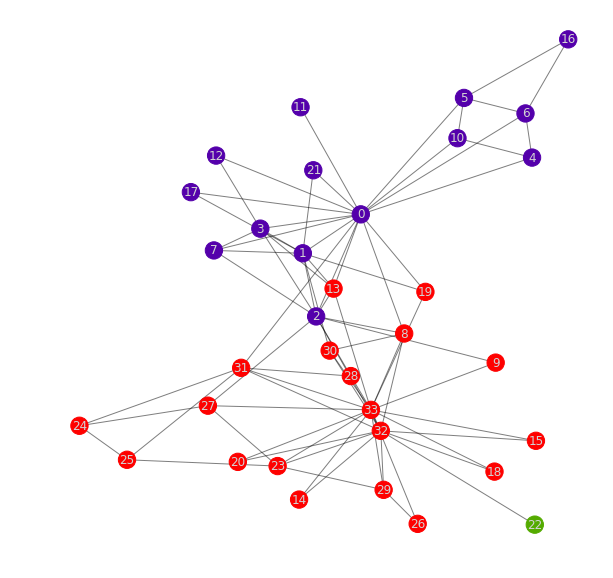

In [16]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, cmap=plt.cm.brg, node_color=node_color_hierarchical, vmin=0.5, vmax=3.5)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_color='lightgray')
plt.show()

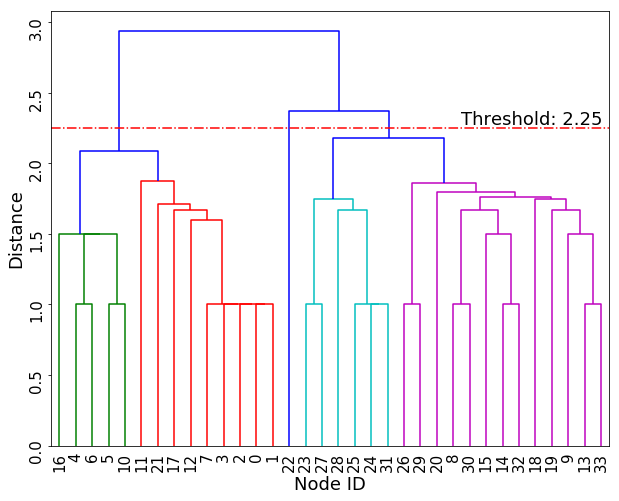

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.set_ylabel('Distance', fontsize=18)
ax.set_xlabel('Node ID', fontsize=18)
hierarchy.dendrogram(Z, ax = ax)
ax.axhline(thr, color='red', linestyle='-.')
ax.text(250, thr * 1.01, 'Threshold: %.2f' % thr, fontsize=18)
ax.tick_params(labelsize=15)
ax.tick_params(axis='both', labelrotation=90)

In [18]:
partition = community.best_partition(G)
node_color_louvain = list(partition.values())

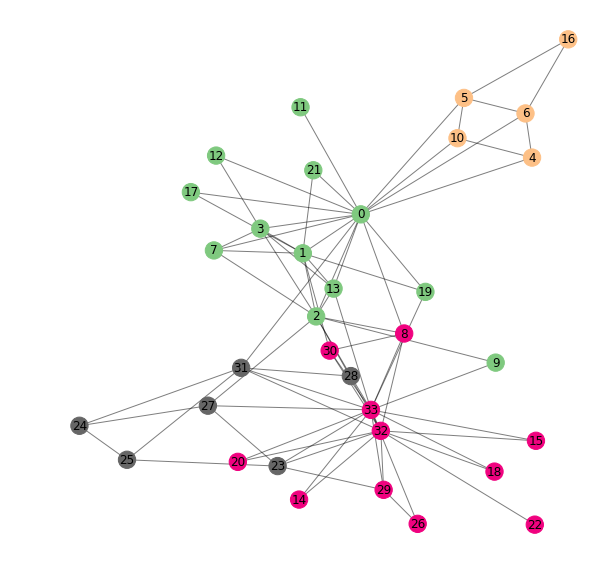

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.axis('off')
nx.draw_networkx_nodes(G, pos, cmap=plt.cm.Accent, node_color=node_color_louvain, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
_ = nx.draw_networkx_labels(G, pos, ax=ax, font_color='black')

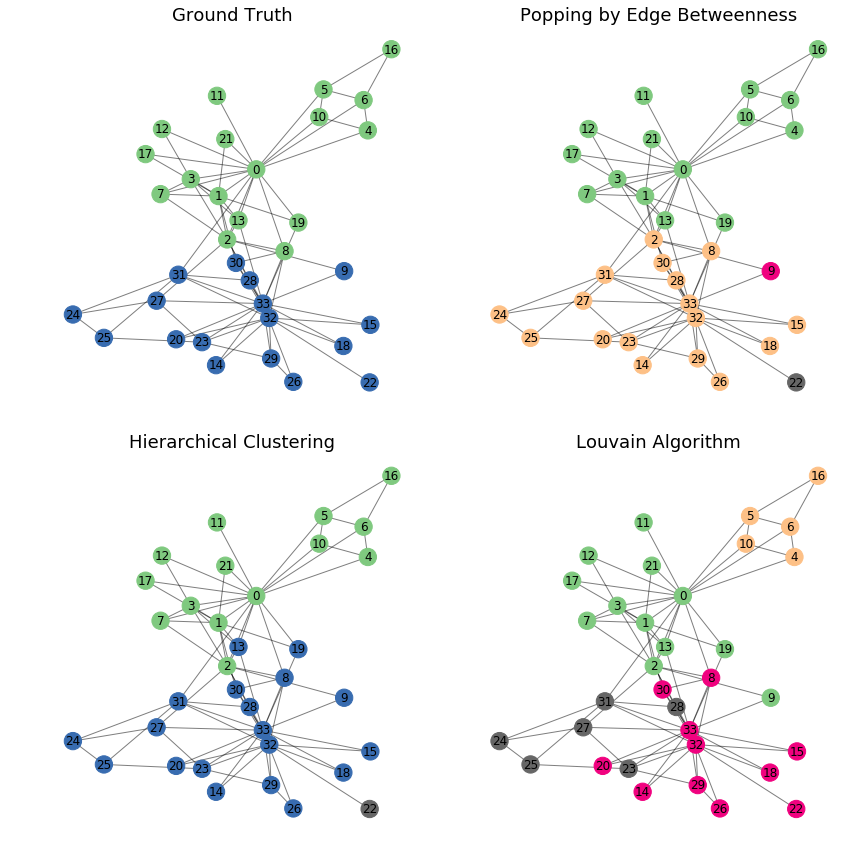

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
[ax.axis('off') for ax in axes.reshape(-1)]

axes[0, 0].set_title('Ground Truth', fontsize=18)
nx.draw_networkx_nodes(G, pos, cmap=plt.cm.Accent, node_color=node_color_members, ax=axes[0, 0], vmin=0, vmax=2)
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=axes[0, 0])
_ = nx.draw_networkx_labels(G, pos, font_color='black', ax=axes[0, 0])

axes[0, 1].set_title('Popping by Edge Betweenness', fontsize=18)
nx.draw_networkx_nodes(G, pos, cmap=plt.cm.Accent, node_color=node_color_edge_betweenness, ax=axes[0, 1])
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=axes[0, 1])
_ = nx.draw_networkx_labels(G, pos, font_color='black', ax=axes[0, 1])

axes[1, 0].set_title('Hierarchical Clustering', fontsize=18)
nx.draw_networkx_nodes(G, pos, cmap=plt.cm.Accent, node_color=node_color_hierarchical, ax=axes[1, 0])
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=axes[1, 0])
_ = nx.draw_networkx_labels(G, pos, font_color='black', ax=axes[1, 0])

axes[1, 1].set_title('Louvain Algorithm', fontsize=18)
nx.draw_networkx_nodes(G, pos, cmap=plt.cm.Accent, node_color=node_color_louvain, ax=axes[1, 1])
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=axes[1, 1])
_ = nx.draw_networkx_labels(G, pos, font_color='black', ax=axes[1, 1])
fig.tight_layout()